In [13]:
import numpy as np
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import numpy as np
np.random.seed(42)

import torch
from torchvision import datasets, transforms


# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, act_fn, use_pooling=True):
        super(CustomCNN, self).__init__()
        
        in_channels = 1  # Assuming grayscale input images

        for i in range(depth):
            # Add convolutional layer
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            
            # Add activation layer
            setattr(self, f"act{i}", act_fn())

            # Add MaxPool2d layer every 2 convolutional layers if use_pooling is set
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            in_channels = num_channels

        flattened_size = in_channels * input_dim * input_dim
        self.fc = nn.Linear(flattened_size, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer_name in list(self._modules.keys())[:-2]:  # excluding fc and logsoftmax
            layer = getattr(self, layer_name)
            x = layer(x)
        
        #print(x.size())  # Print the tensor size before flattening
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.logsoftmax(x)


def generate_cnn(input_dim, output_dim, depth, num_channels, act_fn=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, act_fn, use_pooling)
    return model



# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if debug and batch_idx % 20 == 0:
            print('Train step: {} \tLoss: {:.6f}'.format(
                batch_idx, loss.item()))
        if (batch_idx == params['num_train']):
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            break

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    print("yo")
    
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

def eval_cnn(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            if debug and (epoch+1) % 1 == 0:
                val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
                print('Validation Accuracy: {:.2f}%'.format(val_acc*100))
                
    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model



# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    return nn.Sequential(*new_layers)

def cut_cnn_model(model, cut_point=1, freeze=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]
        
        # Reinitialize weights if layer has parameters (like Conv2d)
        if hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        
        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)


import copy

def cut_cnn_model_orthogonal(model, cut_point=1, freeze=True):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (CustomCNN): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert modules to a list for ease of access
    layers = list(model.named_children())
    
    current_layer = 0
    for name, layer in layers:
        # Check the type of layer and decide on actions
        if isinstance(layer, nn.Conv2d):
            if current_layer < cut_point:
                if freeze:
                    for param in layer.parameters():
                        param.requires_grad = False
            else:
                # Reinitialize weights for layers after the cut point
                weights_init(layer)
            current_layer += 1

    return model



# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        
        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        
# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import random
import torch.nn.init as init

###############################random seed##############################################################################
manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.cuda.manual_seed_all(manualSeed)
cudnn.benchmark = True
########################################################################################################################


######################################Generating 2D orthogonal initialization kernel####################################
#generating uniform orthogonal matrix
def _orthogonal_matrix(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

#generating orthogonal projection matrix,i.e. the P,Q of Algorithm1 in the original
def _symmetric_projection(n):
    """Compute a n x n symmetric projection matrix.
    Args:
      n: Dimension.
    Returns:
      A n x n orthogonal projection matrix, i.e. a matrix P s.t. P=P*P, P=P^T.
    """
    q = _orthogonal_matrix(n)
    # randomly zeroing out some columns
    # mask = math.cast(random_ops.random_normal([n], seed=self.seed) > 0,
    # #                      self.dtype)
    mask = torch.randn(n)

    c = torch.mul(mask,q)
    U,_,_= torch.svd(c)
    U1 = U[:,0].view(len(U[:,0]),1)
    P = torch.mm(U1,U1.t())
    P_orth_pro_mat = torch.eye(n)-P
    return P_orth_pro_mat

#generating block matrix the step2 of the Algorithm1 in the original
def _block_orth(p1, p2):
    """Construct a 2 x 2 kernel. Used to construct orthgonal kernel.
    Args:
      p1: A symmetric projection matrix (Square).
      p2: A symmetric projection matrix (Square).
    Returns:
      A 2 x 2 kernel [[p1p2,         p1(1-p2)],
                      [(1-p1)p2, (1-p1)(1-p2)]].
    Raises:
      ValueError: If the dimensions of p1 and p2 are different.
    """
    if p1.shape != p2.shape:
        raise ValueError("The dimension of the matrices must be the same.")
    kernel2x2 = {}#Block matrices are contained by a dictionary
    eye = torch.eye(p1.shape[0])
    kernel2x2[0, 0] = torch.mm(p1, p2)
    kernel2x2[0, 1] = torch.mm(p1, (eye - p2))
    kernel2x2[1, 0] = torch.mm((eye - p1), p2)
    kernel2x2[1, 1] = torch.mm((eye - p1), (eye - p2))

    return kernel2x2

#compute convolution operator of equation2.17 in the original
def _matrix_conv(m1, m2):
    """Matrix convolution.
    Args:
      m1: A k x k dictionary, each element is a n x n matrix.
      m2: A l x l dictionary, each element is a n x n matrix.
    Returns:
      (k + l - 1) * (k + l - 1) dictionary each element is a n x n matrix.
    Raises:
      ValueError: if the entries of m1 and m2 are of different dimensions.
    """

    n = m1[0, 0].shape[0]
    if n != m2[0, 0].shape[0]:
        raise ValueError("The entries in matrices m1 and m2 "
                         "must have the same dimensions!")
    k = int(np.sqrt(len(m1)))
    l = int(np.sqrt(len(m2)))
    result = {}
    size = k + l - 1
    # Compute matrix convolution between m1 and m2.
    for i in range(size):
        for j in range(size):
            result[i, j] = torch.zeros(n,n)
            for index1 in range(min(k, i + 1)):
                for index2 in range(min(k, j + 1)):
                    if (i - index1) < l and (j - index2) < l:
                        result[i, j] += torch.mm(m1[index1, index2],
                                                        m2[i - index1, j - index2])
    return result

def _dict_to_tensor(x, k1, k2):
    """Convert a dictionary to a tensor.
    Args:
      x: A k1 * k2 dictionary.
      k1: First dimension of x.
      k2: Second dimension of x.
    Returns:
      A k1 * k2 tensor.
    """
    return torch.stack([torch.stack([x[i, j] for j in range(k2)])
                            for i in range(k1)])

#generating a random 2D orthogonal Convolution kernel
def _orthogonal_kernel(tensor):
    """Construct orthogonal kernel for convolution.
    Args:
      ksize: Kernel size.
      cin: Number of input channels.
      cout: Number of output channels.
    Returns:
      An [ksize, ksize, cin, cout] orthogonal kernel.
    Raises:
      ValueError: If cin > cout.
    """
    ksize = tensor.shape[2]
    cin = tensor.shape[1]
    cout = tensor.shape[0]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]#这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth,0),0)

    p = _block_orth(_symmetric_projection(cout),
                         _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                                _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(3,2,1,0))
    return tensor

#defining 2DConvT orthogonal initialization kernel
def ConvT_orth_kernel2D(tensor):
    ksize = tensor.shape[2]
    cin = tensor.shape[0]
    cout = tensor.shape[1]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]  # 这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth, 0), 0)

    p = _block_orth(_symmetric_projection(cout),
                    _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                           _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(2, 3, 1, 0))
    return tensor
#Call method
def weights_init(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            if m.weight.shape[0] > m.weight.shape[1]:
                _orthogonal_kernel(m.weight.data)
                m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
                m.bias.data.zero_()

        elif isinstance(m, nn.ConvTranspose2d):
            if m.weight.shape[1] > m.weight.shape[0]:
                ConvT_orth_kernel2D(m.weight.data)
               # m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
               # m.bias.data.zero_()

           # m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            #m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.zero_()
'''
Algorithm requires The number of input channels cannot exceed the number of output channels.
 However, some questions may be in_channels>out_channels. 
 For example, the final dense layer in GAN. If counters this case, Orthogonal_kernel is replaced by the common orthogonal init'''
'''
for example,
net=nn.Conv2d(3,64,3,2,1)
net.apply(Conv2d_weights_orth_init)
'''

def makeDeltaOrthogonal(in_channels=3, out_channels=64, kernel_size=3, gain=torch.Tensor([1])):
    weights = torch.zeros(out_channels, in_channels, kernel_size, kernel_size)
    out_channels = weights.size(0)
    in_channels = weights.size(1)
    if weights.size(1) > weights.size(0):
        raise ValueError("In_filters cannot be greater than out_filters.")
    q = _orthogonal_matrix(out_channels)
    q = q[:in_channels, :]
    q *= torch.sqrt(gain)
    beta1 = weights.size(2) // 2
    beta2 = weights.size(3) // 2
    weights[:, :, beta1, beta2] = q
    return weights
#Calling method is the same as the above _orthogonal_kernel
######################################################END###############################################################


Random Seed:  5042


### Baseline, end to end trained model

In [3]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
depth = 20

#TODO: the CNN code does not initialize the weights with sw and sb
fashion_dataset = FashionMNISTtrainer(batch_size, input_dim = (1,28,28))
params = dict(device=device,
                width=25, lr=0.01, num_train=4, depth= depth)

fashion_model = generate_cnn(fashion_dataset.input_dim[1], fashion_dataset.output_dim,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

fashion_model.apply(weights_init)

train_acc, test_acc, pretrained_model = compute_training_acc_epochs_cnn(fashion_model, fashion_dataset, params, debug=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 17506007.76it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305228.51it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5608170.92it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7336825.35it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/tmp/ipykernel_28/3619457995.py:22: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  q, r = torch.qr(a)
/tmp/ipykernel_28/3619457995.py:181: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(m.weight.data)


CustomCNN(
  (conv0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (conv7): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act7): ReLU()
  (conv8): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act8): ReLU()
  (conv9): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act9): ReLU()
  (conv10): Conv2d(25, 25, kernel_size=(3, 3), str

Layer conv0 - Variance: 0.005552852060645819
Layer act0 - Variance: 0.0011114487424492836
Layer conv1 - Variance: 0.0018475041724741459
Layer act1 - Variance: 0.001042251824401319
Layer conv2 - Variance: 0.0026062517426908016
Layer act2 - Variance: 0.001672366401180625
Layer conv3 - Variance: 0.004361390136182308
Layer act3 - Variance: 0.002959157107397914
Layer conv4 - Variance: 0.007810404058545828
Layer act4 - Variance: 0.005341494455933571
Layer conv5 - Variance: 0.012616747058928013
Layer act5 - Variance: 0.009763087145984173
Layer conv6 - Variance: 0.02179040014743805
Layer act6 - Variance: 0.01735251024365425
Layer conv7 - Variance: 0.038285914808511734
Layer act7 - Variance: 0.03253321722149849
Layer conv8 - Variance: 0.06439972668886185
Layer act8 - Variance: 0.04438242316246033
Layer conv9 - Variance: 0.07026601582765579
Layer act9 - Variance: 0.04229661077260971
Layer conv10 - Variance: 0.06725111603736877
Layer act10 - Variance: 0.032887715846300125
Layer conv11 - Variance:

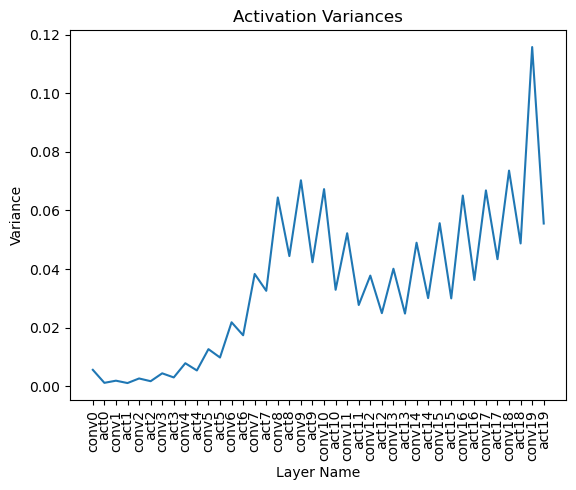

In [4]:
def compute_layer_variances(model, test_loader, device='cpu'):
    # Define a hook to collect activations
    activations = {}

    def create_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            layer.register_forward_hook(create_hook(name))

    # Run inference on the test set
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

    # Calculate and print variance for each layer's activations
    variances = {key: torch.var(act, dim=0) for key, act in activations.items()}
    
    result = {}
    for layer_name, variance in variances.items():
        result[layer_name] = variance.mean().item()

    return result, variances

# Usage:
results, variances = compute_layer_variances(fashion_model, fashion_dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")
    
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()


/tmp/ipykernel_28/3818233106.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/tmp/ipykernel_28/3818233106.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


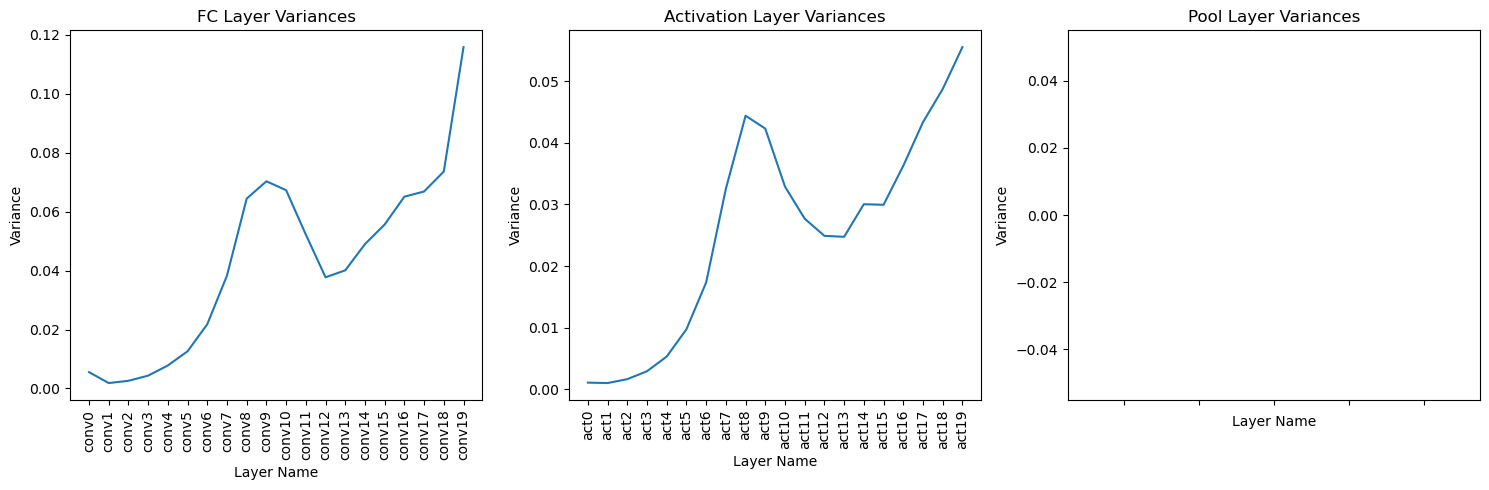

In [5]:
# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the variances for fc layers
axs[0].plot(conv_layer_names, conv_variance_values)
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Plot the variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values)
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Variance')
axs[2].set_title('Pool Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### finetuned staring from fashion mnist to number mnist

In [15]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

number_dataset = MNISTtrainer(batch_size, input_dim = (1,28,28))

cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_cnn_model_orthogonal(fashion_model, cut_point = cut, freeze = True)
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs_cnn(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

/tmp/ipykernel_28/3619457995.py:181: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(m.weight.data)


In [ ]:
results, variances = compute_layer_variances(fashion_model, number_dataset.train_loader, device = 'cuda')
for layer_name, variance in results.items():
    print(f"Layer {layer_name} - Variance: {variance}")
    
import matplotlib.pyplot as plt

# Create a list of layer names and variances
layer_names = list(variances.keys())
variance_values = [variance.mean().item() for variance in variances.values()]

# Plot the variances
plt.plot(layer_names[:-2], variance_values[:-2])
plt.xticks(rotation=90)
plt.xlabel('Layer Name')
plt.ylabel('Variance')
plt.title('Activation Variances')
plt.show()

# Create a list of layer names and variances for fc layers
conv_layer_names = [name for name in variances.keys() if 'conv' in name]
conv_variance_values = [variance.mean().item() for name, variance in variances.items() if 'conv' in name]

# Create a list of layer names and variances for activation layers
activation_layer_names = [name for name in variances.keys() if 'act' in name]
activation_variance_values = [variance.mean().item() for name, variance in variances.items() if 'act' in name]

# Create a list of layer names and variances for pool layers
pool_layer_names = [name for name in variances.keys() if 'pool' in name]
pool_variance_values = [variance.mean().item() for name, variance in variances.items() if 'pool' in name]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the variances for fc layers
axs[0].plot(conv_layer_names, conv_variance_values)
axs[0].set_xticklabels(conv_layer_names, rotation=90)
axs[0].set_xlabel('Layer Name')
axs[0].set_ylabel('Variance')
axs[0].set_title('FC Layer Variances')

# Plot the variances for activation layers
axs[1].plot(activation_layer_names, activation_variance_values)
axs[1].set_xticklabels(activation_layer_names, rotation=90)
axs[1].set_xlabel('Layer Name')
axs[1].set_ylabel('Variance')
axs[1].set_title('Activation Layer Variances')

# Plot the variances for pool layers
axs[2].plot(pool_layer_names, pool_variance_values)
axs[2].set_xticklabels(pool_layer_names, rotation=90)
axs[2].set_xlabel('Layer Name')
axs[2].set_ylabel('Variance')
axs[2].set_title('Pool Layer Variances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [16]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.9414259259259259
Cut 1:
0.9163148148148148
Cut 2:
0.9539444444444445
Cut 3:
0.9437777777777778
Cut 4:
0.9670740740740741
Cut 5:
0.9443888888888889
Cut 6:
0.9677777777777777
Cut 7:
0.9734814814814815
Cut 8:
0.9718333333333333
Cut 9:
0.9655925925925926
Cut 10:
0.9558148148148148
Cut 11:
0.9631851851851851
Cut 12:
0.961037037037037
Cut 13:
0.9631481481481482
Cut 14:
0.9485740740740741
Cut 15:
0.9544444444444444
Cut 16:
0.9634814814814815
Cut 17:
0.9527407407407408
Cut 18:
0.9488333333333333
Cut 19:
0.9400555555555555


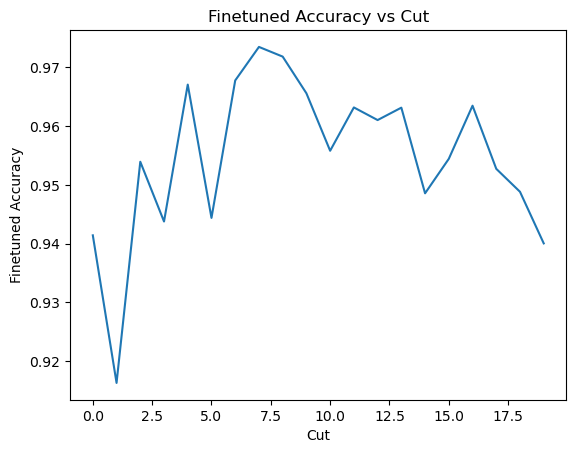

In [18]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----